In [126]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
from torchvision import datasets, transforms
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from torch.utils.data import Subset


In [127]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [128]:
# Define transformations for the KMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Load the KMNIST dataset for training and testing
train_dataset = datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

# train_dataset, _ = random_split(train_dataset, [1000, len(train_dataset) - 1000])
# test_dataset, _ = random_split(test_dataset, [200, len(test_dataset) - 200])


In [129]:
type(train_dataset)

torchvision.datasets.mnist.KMNIST

In [130]:
# Define the neural network architecture
class SimpleANN(nn.Module):
    def __init__(self):
        super(SimpleANN, self).__init__()

        # Define the layers of the neural network
        self.model = nn.Sequential(
            nn.Flatten(),  # Flatten the input from 28x28 to 784
            nn.Linear(28*28, 128),  # First fully connected layer (784 -> 512)
            nn.BatchNorm1d(128),  # Batch normalization
            nn.ReLU(),  # ReLU activation function
            nn.Dropout(0.2),  # Dropout to avoid overfitting

            nn.Linear(128, 64),  # Third fully connected layer (256 -> 128)
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 10),  # Output layer (128 -> 10)
            nn.BatchNorm1d(10)
        )
        self.init_weights()  # Initialize weights

    def init_weights(self):
        # Initialize weights uniformly and set biases to zero
        for module in self.model.modules():
            if isinstance(module, nn.Linear):
                nn.init.uniform_(module.weight, a=-0.1, b=0.1)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        # Forward pass through the network
        x = self.model(x)
        x = F.softmax(x, dim=1)  # Apply softmax to output layer
        return x

In [131]:
# Function to train and evaluate the model using cross-validation
def train_and_evaluate(optimizer_name, learning_rate, batch_size):
    # Perform K-Fold cross-validation with 3 splits
    kf = KFold(n_splits=3)
    accuracy_scores = []
    loss_scores = []
    train_times = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
        print(f"Fold {fold + 1}/{kf.n_splits}")

        # Create data loaders for training and validation
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)

        train_loader_cv = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader_cv = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

        # Instantiate the model and move it to the device (GPU/CPU)
        model = SimpleANN().to(device)

        # Define optimizer based on input string
        if optimizer_name == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        elif optimizer_name == 'rmsprop':
            optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
        elif optimizer_name == 'adamw':
            optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

        # Use Mean Squared Error (MSE) as the loss function
        criterion = nn.CrossEntropyLoss()

        # Training loop
        model.train()  # Set the model to training mode
        start_time = time.time()
        for epoch in range(10):  # Train for 10 epochs
            running_loss = 0.0
            train_correct = 0

            # Iterate over training batches
            for batch_idx, (inputs, targets) in enumerate(train_loader_cv):
                inputs, targets = inputs.to(device), targets.to(device)
                one_hot_targets = F.one_hot(targets, num_classes=10).float()  # One-hot encode targets

                optimizer.zero_grad()  # Zero the parameter gradients
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, one_hot_targets)  # Calculate loss
                loss.backward()  # Backpropagation
                optimizer.step()  # Update weights

                running_loss += loss.item()  # Accumulate loss
                _, predicted = torch.max(outputs, 1)  # Get predicted class
                train_correct += (predicted == targets).sum().item()

            # Calculate training accuracy
            train_loss = running_loss / len(train_loader_cv)
            train_accuracy = train_correct / len(train_sampler)

            # Validation loop
            model.eval()  # Set model to evaluation mode
            val_loss = 0.0
            val_correct = 0
            with torch.no_grad():  # Disable gradient calculation for validation
                for batch_idx, (inputs, targets) in enumerate(val_loader_cv):
                    inputs, targets = inputs.to(device), targets.to(device)
                    one_hot_targets = F.one_hot(targets, num_classes=10).float()
                    outputs = model(inputs)
                    loss = criterion(outputs, one_hot_targets)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    val_correct += (predicted == targets).sum().item()

            # Calculate validation accuracy
            val_loss /= len(val_loader_cv)
            val_accuracy = val_correct / len(val_sampler)

            print(f"  Epoch {epoch + 1}/10 - train_loss: {train_loss:.4f} - train_acc: {train_accuracy:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_accuracy:.4f}")
        # End of fold, record training time
        train_time = time.time() - start_time

        accuracy_scores.append(val_accuracy)  # Append accuracy for this fold
        loss_scores.append(val_loss)
        train_times.append(train_time)

    # Return average accuracy across folds
    return np.mean(accuracy_scores), np.mean(loss_scores), np.mean(train_times)
# List to store results

In [132]:
# # Define hyperparameters for tuning
learning_rates = [0.1, 0.01, 0.001]
batch_sizes = [32, 64, 128]

In [133]:
# Iterate over optimizers, learning rates, and batch sizes
results = []

for optimizer_name in ['adam', 'rmsprop', 'adamw']:
    for lr in learning_rates:
        for bs in batch_sizes:
            print(f"<---------------- Testing {optimizer_name} with learning rate {lr} and batch size {bs} ---------------->")
            accuracy, loss, training_time = train_and_evaluate(optimizer_name, lr, bs)
            results.append((optimizer_name, lr, bs, loss, accuracy, training_time))  # Save results

<---------------- Testing adam with learning rate 0.1 and batch size 32 ---------------->
Fold 1/3
  Epoch 1/10 - train_loss: 1.7547 - train_acc: 0.7108 - val_loss: 1.6327 - val_acc: 0.8299
  Epoch 2/10 - train_loss: 1.7781 - train_acc: 0.6818 - val_loss: 1.7690 - val_acc: 0.6920
  Epoch 3/10 - train_loss: 1.9209 - train_acc: 0.5400 - val_loss: 2.1697 - val_acc: 0.2914
  Epoch 4/10 - train_loss: 2.1101 - train_acc: 0.3510 - val_loss: 2.0967 - val_acc: 0.3644
  Epoch 5/10 - train_loss: 2.2991 - train_acc: 0.1620 - val_loss: 2.3616 - val_acc: 0.0996
  Epoch 6/10 - train_loss: 2.3609 - train_acc: 0.1003 - val_loss: 2.3616 - val_acc: 0.0996
  Epoch 7/10 - train_loss: 2.3609 - train_acc: 0.1003 - val_loss: 2.3616 - val_acc: 0.0996
  Epoch 8/10 - train_loss: 2.3609 - train_acc: 0.1003 - val_loss: 2.3616 - val_acc: 0.0996
  Epoch 9/10 - train_loss: 2.3609 - train_acc: 0.1003 - val_loss: 2.3616 - val_acc: 0.0996
  Epoch 10/10 - train_loss: 2.3609 - train_acc: 0.1003 - val_loss: 2.3616 - val_ac

In [134]:
# Convert results to a DataFrame for comparison
results_df = pd.DataFrame(results, columns=['Optimizer', 'Learning Rate', 'Batch Size', "Loss", 'Accuracy', "Training Time"])
results_df.to_csv('Optimizer_Results.csv')
results_df

,Optimizer,Learning Rate,Batch Size,Loss,Accuracy,Training Time
0,adam,0.100,32,2.284238,0.176917,210.872395
1,adam,0.100,64,2.361175,0.100033,170.714059
2,adam,0.100,128,2.337560,0.123483,149.701033
3,adam,0.010,32,1.782198,0.678950,213.197458
4,adam,0.010,64,1.831122,0.630050,162.162949
5,adam,0.010,128,1.695504,0.765333,146.122388
6,adam,0.001,32,1.538020,0.922683,200.292868
7,adam,0.001,64,1.534908,0.926183,166.860024
8,adam,0.001,128,1.529555,0.932033,149.823922
9,rmsprop,0.100,32,1.840096,0.621050,207.823540


In [135]:
# Find the best results for each optimizer
best_results = results_df.loc[results_df.groupby('Optimizer')['Accuracy'].idxmax()]

# Display best results
print(best_results)

   Optimizer  Learning Rate  Batch Size      Loss  Accuracy  Training Time
8       adam          0.001         128  1.529555  0.932033     149.823922
26     adamw          0.001         128  1.528170  0.933200     148.415535
17   rmsprop          0.001         128  1.526891  0.934417     145.459054


In [137]:
bar_colors = ['skyblue', 'salmon', 'lightgreen']

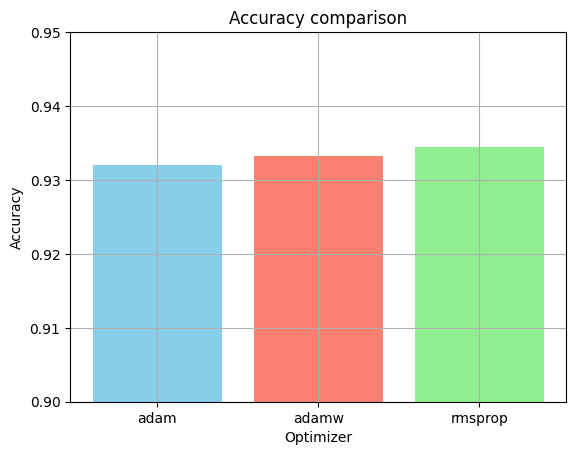

In [145]:

plt.bar(best_results['Optimizer'], best_results['Accuracy'], color=bar_colors)
# Display the graphs
plt.xlabel('Optimizer')
plt.ylabel('Accuracy')
plt.title('Accuracy comparison')
plt.ylim([0.9, 0.95])
plt.grid(True)
plt.show()

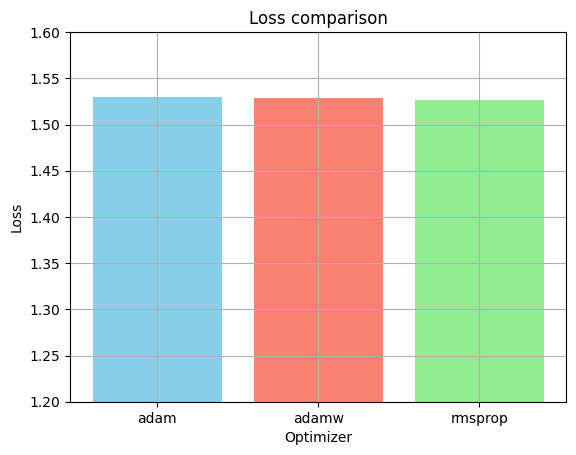

In [149]:

plt.bar(best_results['Optimizer'], best_results['Loss'], color=bar_colors)
# Display the graphs
plt.xlabel('Optimizer')
plt.ylabel('Loss')
plt.title('Loss comparison')
plt.grid(True)
plt.ylim([1.2, 1.6])
plt.show()

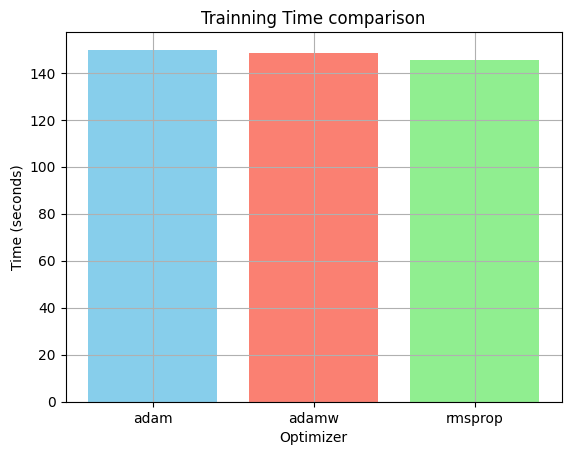

In [150]:
plt.bar(best_results['Optimizer'], best_results['Training Time'], color=bar_colors)
# Display the graphs
plt.xlabel('Optimizer')
plt.ylabel('Time (seconds)')
plt.title('Trainning Time comparison')
plt.grid(True)
plt.show()